Generate edges.csv and nodes.csv file for OpenRidepoolSimulator

authors
- Youngseo Kim (yk796@cornell.edu)
- Michael P Wilbur (michael.p.wilbur@vanderbilt.edu)

In [1]:
import geopandas as gpd
import pandas as pd
import os
from pathlib import Path
import datetime as dt
import time
from copy import deepcopy
import numpy as np
import osmnx as ox
import networkx as nx
import scipy
import sys
import pickle
import math
from collections import defaultdict
from heapq import *
import numpy as np
import random
import datetime
import matplotlib.pyplot as plt
from scipy.optimize import fmin

In [2]:
CURRENT_DIR = Path(r"%s"%os.getcwd()).parent

# make path if not exist
OUTPUT_DIR = os.path.join(CURRENT_DIR, "data", "map")
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)
INT = False

In [3]:
# author: Michael P Wilbur (michael.p.wilbur@vanderbilt.edu)
# Note that OpenRidepoolSimulator requests network to be strongly connected
def osmnx_routing_graph(addr='Chattanooga, Tennessee', 
                        buffer_dist=500, 
                        strongly_connected=True, 
                        integer_edge_weights=True):
    """
    Uses OSMNX to get OSM routing graph for a city. Returns the routing graph (networkx)
    as well as the nodes and edges as pandas DataFrames. buffer_dist will expand the
    OSM network by buffer_dist (meters) in all directions. If strongly_connected then return
    the largest strongly connected component, if false return largest weakly connected component.
    If integer_edge_weights, then edge weights (travel time) is rounded up to nearest integer.
    
    :param addr: str
    :param buffer_dist: int
    :param strongly_connected: bool
    :param integer_edge_weights: bool
    :return: networkx.MultiDiGraph, pandas.DataFrame, pandas.DataFrame
    """
    # get the OSM graph
    G = ox.graph_from_place('Chattanooga, Tennessee',
                            network_type='drive',
                            simplify=True,
                            truncate_by_edge=True,
                            retain_all=False,
                            buffer_dist=buffer_dist)
    G = ox.utils_graph.get_largest_component(G, strongly=strongly_connected)

    # add edge speeds
    G = ox.speed.add_edge_speeds(G, fallback=40.2, precision=6)

    # add edge travel time
    G = ox.speed.add_edge_travel_times(G, precision=6)
    if integer_edge_weights:
        for n1, n2, k in G.edges(keys=True):
            G[n1][n2][k]['travel_time'] = math.ceil(G[n1][n2][k]['travel_time'])


    nodes, edges = ox.utils_graph.graph_to_gdfs(G)

    # format nodes
    nodes['osmid'] = nodes.index
    nodes.index = range(len(nodes))
    nodes['node_id'] = nodes.index
    nodes['lon'] = nodes['x']
    nodes['lat'] = nodes['y']
    nodes = nodes[['node_id', 'osmid', 'lat', 'lon']]
    nodes['node_id'] = nodes['node_id'].astype(int)
    nodes['osmid'] = nodes['osmid'].astype(int)
    nodes['lat'] = nodes['lat'].astype(float)
    nodes['lon'] = nodes['lon'].astype(float)

    # format edges
    edges = edges.reset_index()
    edges['source_osmid'] = edges['u']
    edges['target_osmid'] = edges['v']
    edges['source_node'] = edges['source_osmid'].apply(lambda x: nodes.loc[nodes['osmid']==x, 'node_id'].values[0])
    edges['target_node'] = edges['target_osmid'].apply(lambda x: nodes.loc[nodes['osmid']==x, 'node_id'].values[0])
    edges = edges.sort_values(by=['travel_time'])
    edges = edges.drop_duplicates(subset=['source_node', 'target_node'])
    edges = edges[['source_osmid', 'target_osmid', 'source_node', 'target_node', 'travel_time']]
    edges['source_osmid'] = edges['source_osmid'].astype(int)
    edges['target_osmid'] = edges['target_osmid'].astype(int)
    edges['source_node'] = edges['source_node'].astype(int)
    edges['target_node'] = edges['target_node'].astype(int)
    edges['travel_time'] = edges['travel_time'].astype(int)
    # format edge types
    print(f"Number of nodes: {len(nodes)}, number of edges: {len(edges)}")
    return G, nodes, edges


In [4]:
# author: Matthew Zalesak mdz32@cornell.edu

def four_traveltimes():
    inputname = OUTPUT_DIR + '/edges.csv'
    outputname = OUTPUT_DIR + '/times.csv'
    #MULTIPLIER = float(settings['scale'])

    print('\tBuilding internal network...')
    nodecount = 0
    edges = {}
    with open(inputname) as fin:
        for line in fin:
            origin, destination, length = map(int, line[:-1].split(','))
            nodecount = max(nodecount, origin, destination)
            origin -= 1
            destination -= 1
            edges[(origin, destination)] = length # int(round(MULTIPLIER * length))

    network = defaultdict(list)
    for (origin, destination), cost in edges.items():
        network[origin].append((destination, cost))

    def dijkstras(i):
        q = [(0, i, ())]  # (distance, id, path)
        visited = set()
        bests = {i : 0}

        while q:
            (cost, o, path) = heappop(q)        # Closest node on the frontier.
            if o not in visited:                # For each source... (if unprocessed)
                visited.add(o)                  # Note this has been processed and then extend reverse path.
                path = (o, path)                # Path does nothing here.

                for d, cost_d in network.get(o, ()):        # For each destination
                    if d not in visited:                    # If it might be on the frontier...
                        prev = bests.get(d, None)           # Try to get existing estimate of distance.
                        new = cost + cost_d                 # Judge distance via waypoint o.
                        if prev is None or new < prev:      # If this is best path found so far...
                            bests[d] = new                  # This is the best distance!
                            heappush(q, (new, d, path))     # Pop it on the queue!

        return bests

    # Instead of this old way, will do more space efficient version!
    # results = 10000 * np.ones(dtype = int, shape = (nodecount, nodecount))

    print('\tComputing all pairs shortest distances and writing results to file...')
    print('\tThere are', nodecount, 'rows to process.')
    with open(outputname, 'w') as fout:
        for origin in range(nodecount):
            results = 10000 * np.ones(dtype = int, shape = (nodecount,))
            if origin % 100 == 0:
                print('\t\tWorking on line', origin)
            paths = dijkstras(origin)
            for destination, cost in paths.items():
                results[destination] = cost
            fout.write(','.join(map(str, results)))
            fout.write('\n')

Number of nodes: 10723, number of edges: 27402


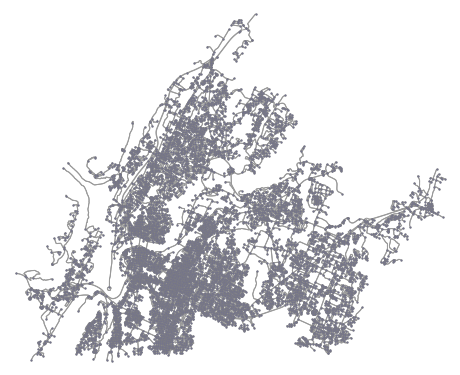

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [5]:
G, nodes, edges = osmnx_routing_graph(addr='Chattanooga, Tennessee', 
                        buffer_dist=500, 
                        strongly_connected=True, 
                        integer_edge_weights=True)
ox.plot_graph(G, node_color='b', node_size=2, node_edgecolor='grey', bgcolor = 'white')

In [6]:
# format and save nodes.csv and edges.csv for PNAS Simulator Format

nodes['node_id'] = nodes['node_id'].apply(lambda x: x + 1)
nodes = nodes[['node_id', 'lat', 'lon']]
file_path = os.path.join(OUTPUT_DIR, 'nodes.csv')
nodes.to_csv(file_path, header=False, index=False)

edges['source_node'] = edges['source_node'].apply(lambda x: x + 1)
edges['target_node'] = edges['target_node'].apply(lambda x: x + 1)
edges['travel_time'] = edges['travel_time'].apply(lambda x: math.ceil(x))
edges = edges[['source_node', 'target_node', 'travel_time']]
file_path = os.path.join(OUTPUT_DIR, 'edges.csv')
edges.to_csv(file_path, header=False, index=False)

In [7]:
# compute and save times.csv 
four_traveltimes()

	Building internal network...
	Computing all pairs shortest distances and writing results to file...
	There are 10723 rows to process.
		Working on line 0
		Working on line 100
		Working on line 200
		Working on line 300
		Working on line 400
		Working on line 500
		Working on line 600
		Working on line 700
		Working on line 800
		Working on line 900
		Working on line 1000
		Working on line 1100
		Working on line 1200
		Working on line 1300
		Working on line 1400
		Working on line 1500
		Working on line 1600
		Working on line 1700
		Working on line 1800
		Working on line 1900
		Working on line 2000
		Working on line 2100
		Working on line 2200
		Working on line 2300
		Working on line 2400
		Working on line 2500
		Working on line 2600
		Working on line 2700
		Working on line 2800
		Working on line 2900
		Working on line 3000
		Working on line 3100
		Working on line 3200
		Working on line 3300
		Working on line 3400
		Working on line 3500
		Working on line 3600
		Working on line 3700
		W

Generate requests.csv file for OpenRidepoolSimulator

Output data should contain the following columns: request id, origin node, optional origin lon, optional origin lat, destination node, optional dest lon, optional dest lat, time

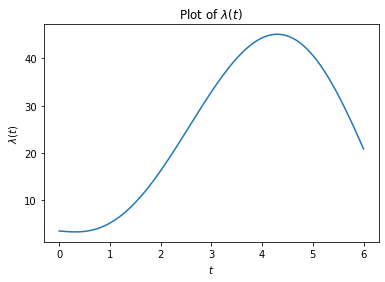

In [8]:
# assume heterogeneous Poisson point process
def lamb(t):
    customers_per_minute = (np.power(t,3) + 1)*np.power((-t + 7.2),2)/900
    customers_per_hour = customers_per_minute*60
    return customers_per_hour

t_list = np.arange(0,6,0.001)
plt.plot(t_list, [lamb(t) for t in t_list])
plt.xlabel('$t$')
plt.ylabel('$\lambda(t)$')
plt.title('Plot of $\lambda(t)$')
plt.show()

In [9]:
# apply the thinning method to generate samples from the given heterogeneous Poisson point process.

def tinning():
    """Simulate request arrivals via the thinning method."""
    lamb_star = lamb(fmin(lambda x: -lamb(x), 4)[0])
    M = np.random.poisson(lam=6*lamb_star)
    T_star = np.sort(6 * np.random.uniform(0,1,M))
    U = np.random.uniform(0,1,M)
    return T_star[lamb_star*U <= lamb(T_star)]

Optimization terminated successfully.
         Current function value: -45.137615
         Iterations: 12
         Function evaluations: 24


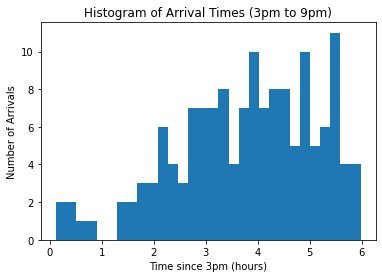

In [10]:
arrival_times = tinning()
plt.hist(arrival_times, bins=30)
plt.title('Histogram of Arrival Times (3pm to 9pm)')
plt.xlabel('Time since 3pm (hours)')
plt.ylabel('Number of Arrivals')
plt.show()

In [11]:
def hour_to_datetime(hour_infloat):
    """convert float to timestamp"""
    target_datetime = datetime.datetime(2021, 1, 1, 15, 0, 0)
    delta = datetime.timedelta(seconds=int(3600*hour_infloat))
    dt = target_datetime + delta
    return dt.time()

In [12]:
# create request times
requests_head = pd.DataFrame(columns = ['time'])
requests_head['time'] = [hour_to_datetime(hour_infloat) for hour_infloat in arrival_times]

# create request locations
column_names=['origin node', 'origin lat', 'origin lon', 'destin node', 'destin lat', 'destin lon']
requests_tail = pd.DataFrame(columns = column_names)
for _ in range(len(requests_head)):
    # from node, select node_id randomly and get corresponding lat/lon.
    ori, des = random.sample(nodes.index.to_list(), 2) # sample ori, des, each without replacement
    trip = nodes.iloc[ori].tolist() + nodes.iloc[des].tolist()
    requests_tail = requests_tail.append(pd.Series(trip, index=column_names), ignore_index=True)

# final formatting 
requests = pd.concat([requests_tail, requests_head], axis=1)
requests['origin node'] = requests['origin node'].astype('int')
requests['destin node'] = requests['destin node'].astype('int')
requests = requests[['origin node', 'origin lon', 'origin lat', 'destin node', 'destin lon', 'destin lat', 'time']]

# write to output format
output_dir = '../data/requests'
if not os.path.exists(output_dir):
    os.mkdir(output_dir)
requests.to_csv(output_dir+'/requests.csv', header = False)

In [13]:
requests

,origin node,origin lon,origin lat,destin node,destin lon,destin lat,time
0,5455,-85.354931,34.995201,2067,-85.209014,35.168437,15:07:27
1,8946,-85.290203,35.025141,10067,-85.318327,35.081522,15:15:56
2,7979,-85.249774,35.117581,8436,-85.310724,35.008064,15:19:32
3,6211,-85.301861,35.061367,6455,-85.226270,35.176212,15:26:38
4,2375,-85.197710,35.081364,1149,-85.155652,35.054357,15:34:54
...,...,...,...,...,...,...,...
142,10576,-85.056497,35.086473,4082,-85.308247,35.075314,20:46:07
143,3730,-85.310172,35.035152,4150,-85.271089,35.020964,20:47:46
144,7440,-85.295317,35.008600,1845,-85.288710,35.021179,20:50:40
145,2429,-85.063211,35.075938,6240,-85.250334,35.071863,20:56:36


Generate vehicles.csv file for OpenRidepoolSimulator

Output data should contain the following columns: vehicle id (starting from 1), start node id, node lat, node lon, start time, capacity 

In [14]:
def generate_vehicles(vehicle_num, vehicle_capacity):
    vehicles = pd.DataFrame()
    # randomly generate starting points 
    start_node = random.sample(nodes.index.to_list(), vehicle_num)
    for n in start_node:
        vehicles = vehicles.append(nodes.iloc[n], ignore_index=True)
    
    vehicles.columns = ['node id', 'node lat', 'node lon']
    vehicles['vehicle id'] = list(range(1, vehicle_num+1))
    vehicles['start time'] = datetime.time(0,0,0)
    vehicles['capacity'] = vehicle_capacity
    
    # formatting
    vehicles['node id'] = vehicles['node id'].astype('int')
    vehicles = vehicles[['vehicle id', 'node id', 'node lat', 'node lon', 'start time', 'capacity']]
    return vehicles

vehicles = generate_vehicles(100, 8)

In [15]:
vehicles

,vehicle id,node id,node lat,node lon,start time,capacity
0,1,4597,35.031800,-85.306805,00:00:00,8
1,2,5509,34.991847,-85.287481,00:00:00,8
2,3,7930,35.007759,-85.211644,00:00:00,8
3,4,1921,35.002531,-85.285132,00:00:00,8
4,5,9599,35.078510,-85.081345,00:00:00,8
...,...,...,...,...,...,...
95,96,667,35.112956,-85.293515,00:00:00,8
96,97,3542,35.000312,-85.290721,00:00:00,8
97,98,8580,35.158496,-85.249080,00:00:00,8
98,99,5636,35.086545,-85.178380,00:00:00,8


In [16]:
# write to output format
output_dir = '../data/vehicles'
if not os.path.exists(output_dir):
    os.mkdir(output_dir)
vehicles.to_csv(output_dir+'/vehicles.csv', index = False, header = False)